In [1]:
import sys
import os
import csv
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm_notebook as tqdm

from statsmodels.graphics.tsaplots import plot_acf

sns.set_style('darkgrid')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [11]:
# example_train = pd.read_csv('../inputs/train.csv',nrows=100)
# example_train.info(verbose=True)
# date, weight, resp, resp_1-4, feature_0-129, ts_id 
# date: integer which represents the day of the trade
# ts_id: time ordering

In [79]:
feature_meta = pd.read_csv('../inputs/features.csv')
# feature_meta.info()
# 29 bool tags for all 130 features

In [207]:
example_test = pd.read_csv('../inputs/example_test.csv')
# ts_id increaseing monotonically by 1 to 15218
# date: approx 3 days 0,1 and a little of 2
# 15219 in size
# resp_1-4 not in test set
# weight included

In [262]:
example_test.head()

,date,weight,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id
0,0,0.000,1,-1.873,-2.191,-0.474,-0.323,0.015,-0.002,nan,...,nan,1.168,8.314,1.782,14.018,2.653,12.600,2.301,11.446,0
1,0,16.674,-1,-1.350,-1.705,0.068,0.028,0.194,0.138,nan,...,nan,-1.179,1.777,-0.915,2.832,-1.417,2.297,-1.305,1.899,1
2,0,0.000,-1,0.813,-0.256,0.806,0.400,-0.614,-0.355,nan,...,nan,6.116,9.668,5.543,11.672,7.282,10.060,6.638,9.427,2
3,0,0.000,-1,1.174,0.345,0.067,0.009,-1.006,-0.676,nan,...,nan,2.839,0.499,3.034,1.513,4.398,1.266,3.856,1.013,3
4,0,0.139,1,-3.172,-3.093,-0.162,-0.128,-0.195,-0.144,nan,...,nan,0.345,4.101,0.614,6.623,0.800,5.233,0.363,3.927,4


## Explore Returns and Weights


In [39]:
%%time
train_tar = pd.read_csv('../inputs/train.csv',usecols=['date','ts_id','weight','resp','resp_1','resp_2','resp_3','resp_4'])
train_tar['return'] = train_tar['weight']*train_tar['resp']

CPU times: user 33.9 s, sys: 1.94 s, total: 35.8 s
Wall time: 1min 21s


In [40]:
train_tar.shape

(2390491, 9)

In [115]:
train_tar.head()

,date,weight,resp_1,resp_2,resp_3,resp_4,resp,ts_id,return
0,0,0.000,0.010,0.014,0.009,0.001,0.006,0,0.000
1,0,16.674,-0.003,-0.003,-0.007,-0.011,-0.010,1,-0.163
2,0,0.000,0.025,0.028,0.033,0.034,0.024,2,0.000
3,0,0.000,-0.005,-0.003,-0.000,-0.000,-0.003,3,-0.000
4,0,0.139,0.001,0.002,-0.001,-0.006,-0.003,4,-0.000


Text(0.5, 1.0, 'Weight Histogram')

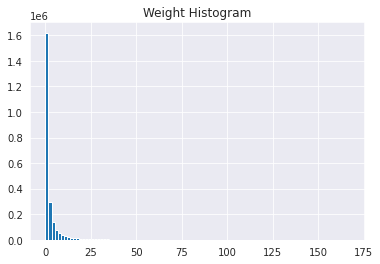

In [117]:
train_tar['weight'].hist(bins=100)
plt.title('Weight Histogram')

Text(0.5, 1.0, 'Resp 0 Histogram')

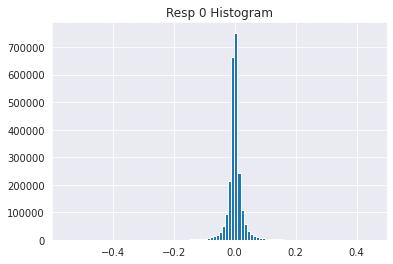

In [118]:
train_tar['resp'].hist(bins=100)
plt.title('Resp 0 Histogram')

In [121]:
print("Sum of Return: ", train_tar['return'].sum())
print("Percent 0 weight: ", train_tar[train_tar['weight']==0].shape[0]/train_weights.shape[0])
print("Min Resp: ",train_tar['resp'].min())
print("Max Resp: ",train_tar['resp'].max())
print("Max Weight: ",train_tar['weight'].max())

Sum of Return:  -473.5675897960236
Percent 0 weight:  0.17117989567833553
Min Resp:  -0.5493844963458359
Max Resp:  0.4484615812436584
Max Weight:  167.2937151011765


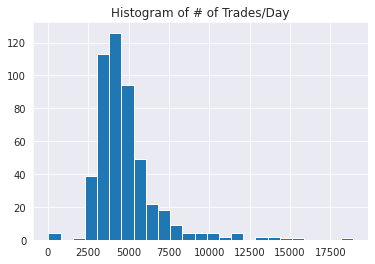

In [68]:
plt.title('Histogram of # of Trades/Day')
plt.hist(train_tar['date'].value_counts().values, bins=25);

In [51]:
train_tar_grouped = train_tar.groupby('date').agg({'resp':['mean','std','count'],
                                                    'weight':['mean','std','count']})
train_tar_grouped['interval'] = (2.58*train_tar_grouped[('resp','std')]/
                                 (train_tar_grouped[('resp','count')].apply(lambda x: math.sqrt(x))))
train_tar_grouped['interval_95'] = train_tar_grouped[('resp','mean')] + train_tar_grouped['interval']
train_tar_grouped['interval_05'] = train_tar_grouped[('resp','mean')] - train_tar_grouped['interval']

Text(0.5, 1.0, 'Average Daily Resp')

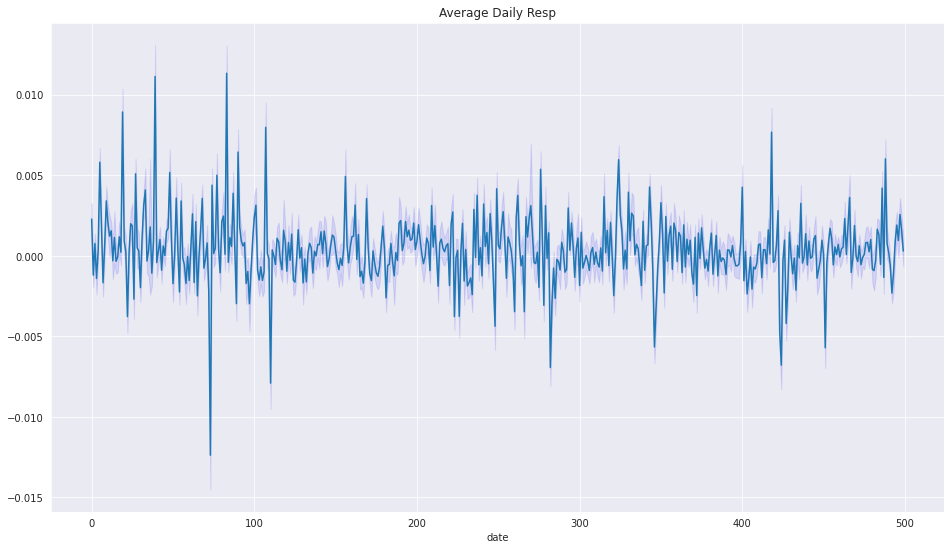

In [99]:
train_tar_grouped[('resp','mean')].plot(figsize=(16,9))
plt.fill_between(train_tar_grouped.index,
                 train_tar_grouped['interval_05'].values,
                 train_tar_grouped['interval_95'].values, 
                 color='blue',
                 alpha=0.1)
plt.title('Average Daily Resp')

In [248]:
all_resp = train_tar.iloc[:, 2:7].values
all_resp = np.where(all_resp > 0, 1, 0)
all_resp = np.sum(all_resp, axis=1)

In [249]:
all_resp[(all_resp != 5) & (all_resp != 0)].shape[0]/train_tar.shape[0]

0.4784665577071823

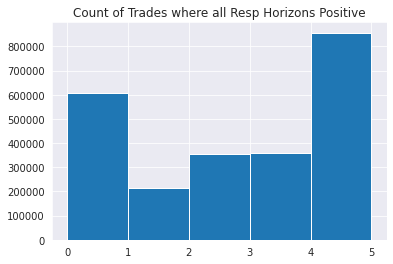

In [286]:
plt.hist(all_resp, bins=5)
plt.title('Count of Trades where all Resp Horizons Positive');

- Half of examples have varying return between positive/negative over orginal resp and 4 horizons

### Explore Raw Features

In [2]:
%%time
dtype_dict = {}
for f in range(0,130):
    dtype_dict[f'feature_{f}'] = 'float16'
train = pd.read_csv('../inputs/train.csv', dtype=dtype_dict)

CPU times: user 1min 10s, sys: 2.04 s, total: 1min 12s
Wall time: 1min 59s


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390491 entries, 0 to 2390490
Columns: 138 entries, date to ts_id
dtypes: float16(130), float64(6), int64(2)
memory usage: 738.6 MB


In [4]:
train.head()

,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,...,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id
0,0,0.000,0.010,0.014,0.009,0.001,0.006,1.000,-1.873,-2.191,...,nan,1.168,8.312,1.782,14.016,2.652,12.602,2.301,11.445,0
1,0,16.674,-0.003,-0.003,-0.007,-0.011,-0.010,-1.000,-1.350,-1.705,...,nan,-1.179,1.777,-0.916,2.832,-1.417,2.297,-1.305,1.898,1
2,0,0.000,0.025,0.028,0.033,0.034,0.024,-1.000,0.813,-0.256,...,nan,6.117,9.664,5.543,11.672,7.281,10.062,6.637,9.430,2
3,0,0.000,-0.005,-0.003,-0.000,-0.000,-0.003,-1.000,1.175,0.345,...,nan,2.838,0.499,3.033,1.514,4.398,1.266,3.855,1.014,3
4,0,0.139,0.001,0.002,-0.001,-0.006,-0.003,1.000,-3.172,-3.094,...,nan,0.345,4.102,0.614,6.625,0.800,5.234,0.363,3.926,4


In [5]:
train['target'] = train['resp']*train['weight']

In [6]:
raw_feature_cols = [f"feature_{f}" for f in range(0,130)]

In [7]:
%%time
correlation = train.corr()

CPU times: user 1min 56s, sys: 736 ms, total: 1min 57s
Wall time: 1min 57s


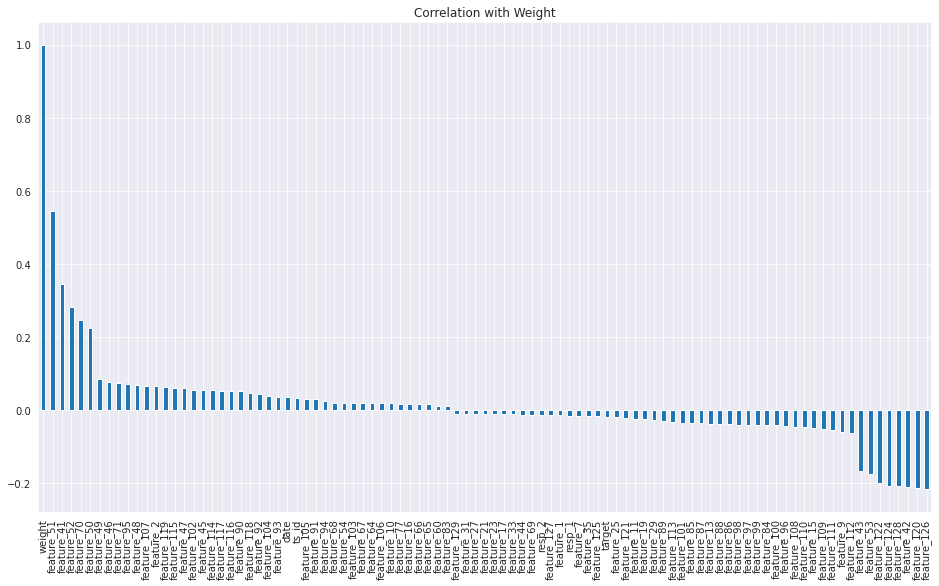

In [8]:
weight_corr = correlation['weight'].sort_values(ascending=False)
weight_corr = weight_corr[(weight_corr > 0.01) | (weight_corr < -0.01)]
weight_corr.plot(kind='bar', figsize=(16,9))
plt.title('Correlation with Weight');

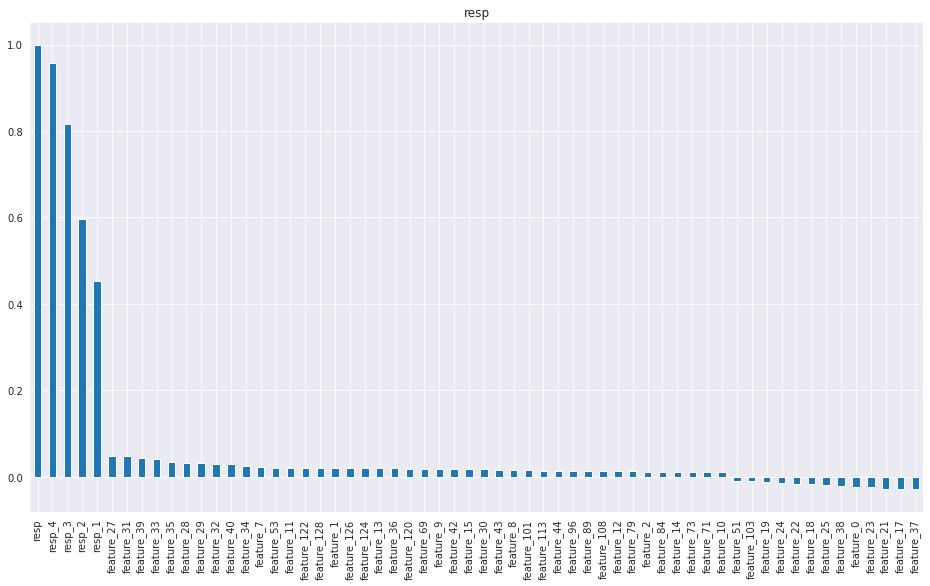

CPU times: user 8.5 s, sys: 2.11 s, total: 10.6 s
Wall time: 29.9 s


In [96]:
%%time
for r in ['resp','resp_1','resp_2','resp_3','resp_4']:
    resp_corr = correlation[r].sort_values(ascending=False)
    resp_corr = resp_corr[(resp_corr > 0.01) | (resp_corr < -0.01)]
    resp_corr.plot(kind='bar', figsize=(16,9))
    plt.title("Correlation with ," r)
    plt.show();
    break # comment out if you want to see all resp horizon correlations

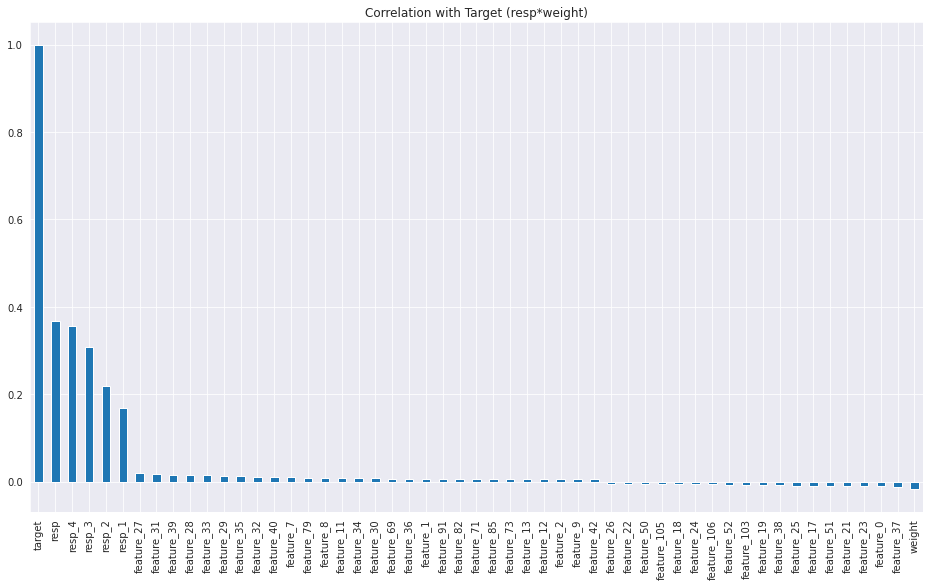

In [105]:
target_corr = correlation['target'].sort_values(ascending=False)
target_corr = target_corr[(target_corr > 0.005) | (target_corr < -0.005)]
target_corr.plot(kind='bar', figsize=(16,9))
plt.title('Correlation with Target (resp*weight)');

In [268]:
def plot_feature_histogram(df, n, col_names, apply_trans=False):
    
    fig, axs = plt.subplots(n, n, figsize=(15,15))
    axs = axs.flatten()
    
    if apply_trans:
        for i, ax in enumerate(axs):
            feat = col_names[i]
            ax.hist(np.power(train[feat].values.astype('float64'),1/3), bins=100)
            ax.set_title(feat)  
    else:
        for i, ax in enumerate(axs):
            feat = col_names[i]
            ax.hist(train[feat].values, bins=100)
            ax.set_title(feat)

    plt.show()
    plt.tight_layout();
    
    return None

### Investigate Feature Distributions Randomly

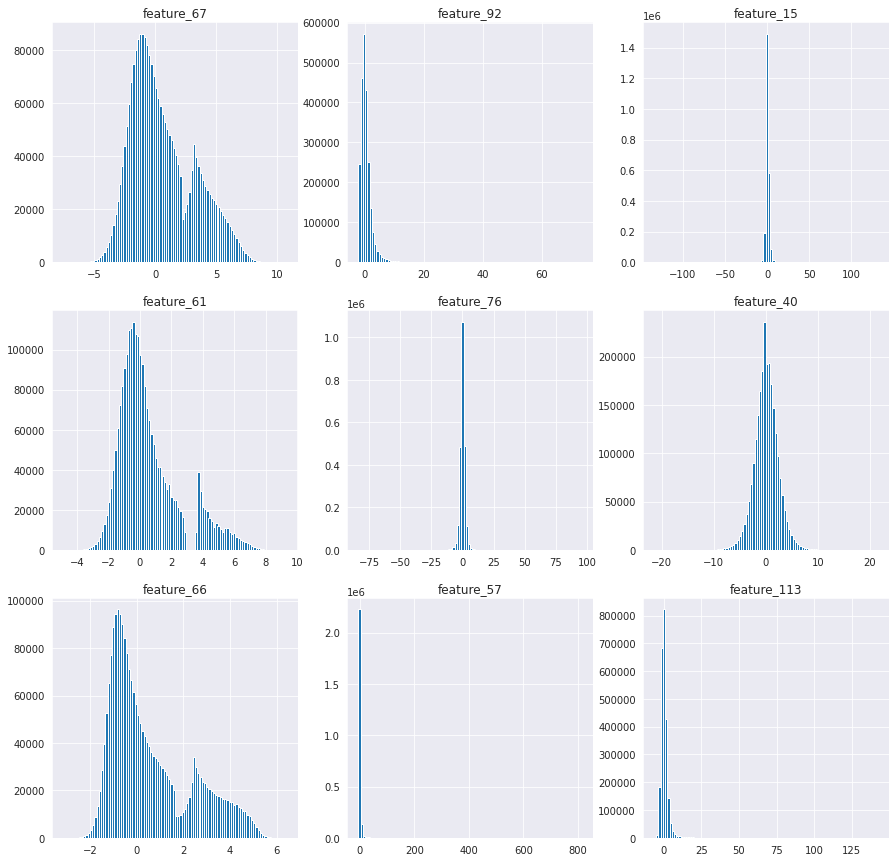

<Figure size 432x288 with 0 Axes>

In [109]:
n = 3
random_features = random.sample(raw_feature_cols,n**2)
plot_feature_histogram(train,n,random_features)

### Investigate Feature Distributions Selectively

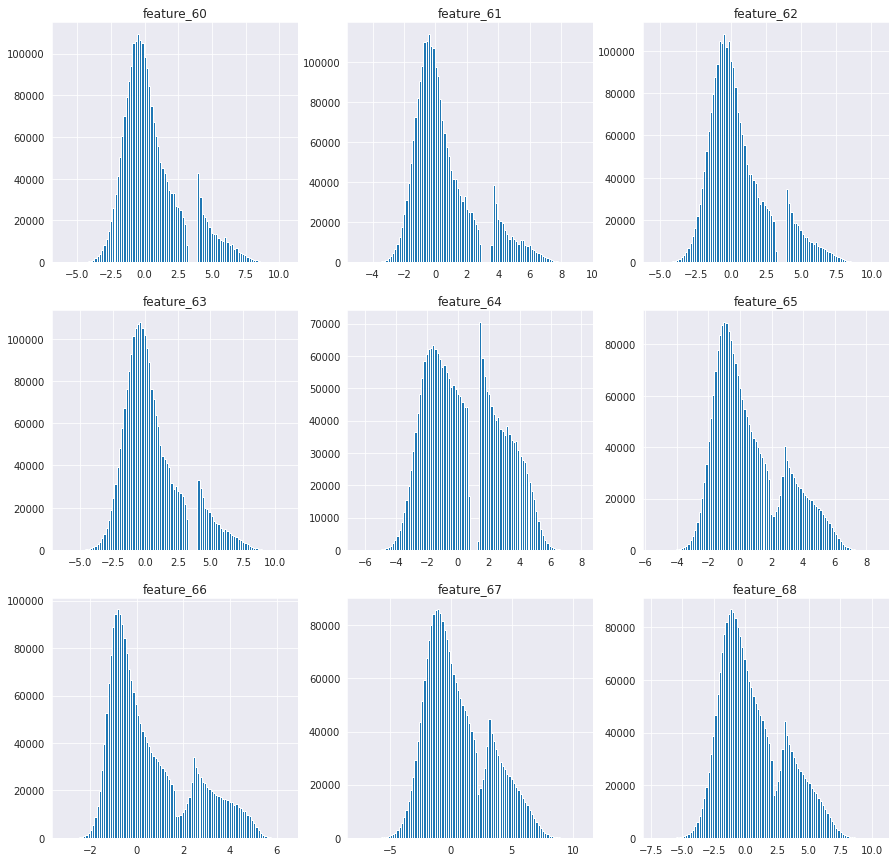

CPU times: user 6.56 s, sys: 98.6 ms, total: 6.66 s
Wall time: 7.67 s


<Figure size 432x288 with 0 Axes>

In [291]:
%%time
n = 3
start_feat_num = 60
select_features = ['feature_'+str(i) for i in range(start_feat_num,start_feat_num+(n**2))]
plot_feature_histogram(train,n,select_features)

### Investigate Top Positive Correlated Distributions

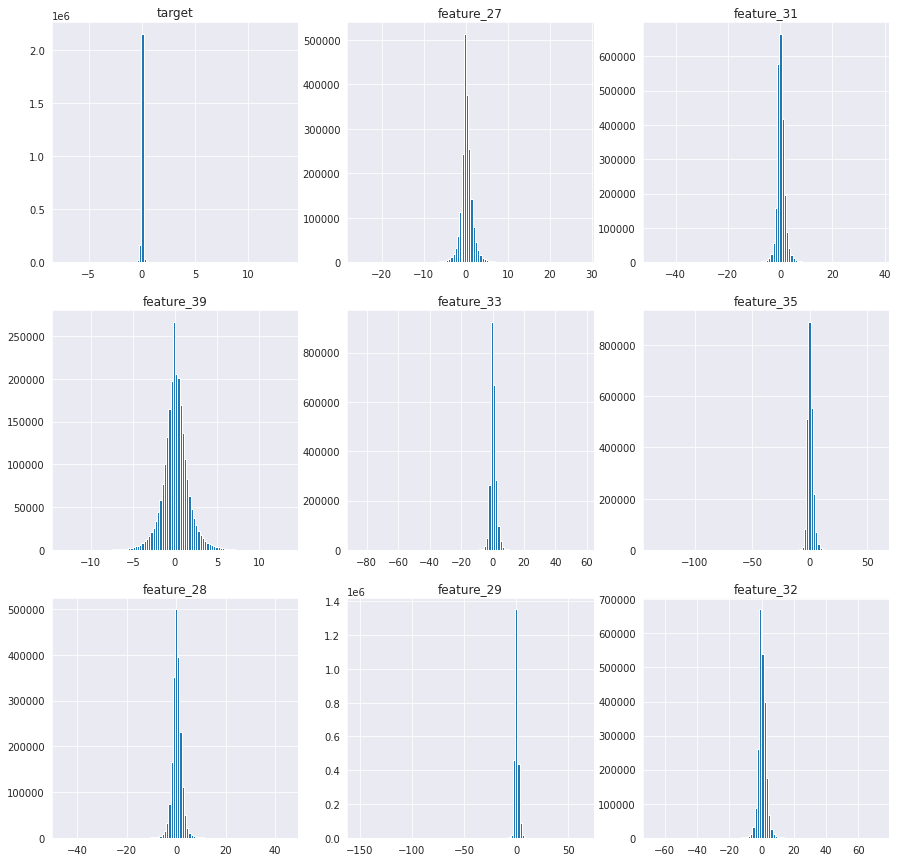

CPU times: user 6.73 s, sys: 312 ms, total: 7.04 s
Wall time: 8.52 s


<Figure size 432x288 with 0 Axes>

In [112]:
%%time
n = 3
top_corr = correlation['resp'].sort_values(ascending=False)[5:].head(n**2)
corr_features = top_corr.index.tolist()
plot_feature_histogram(train,n,corr_features)

### Investigate Top  Negative Correlated Distributions

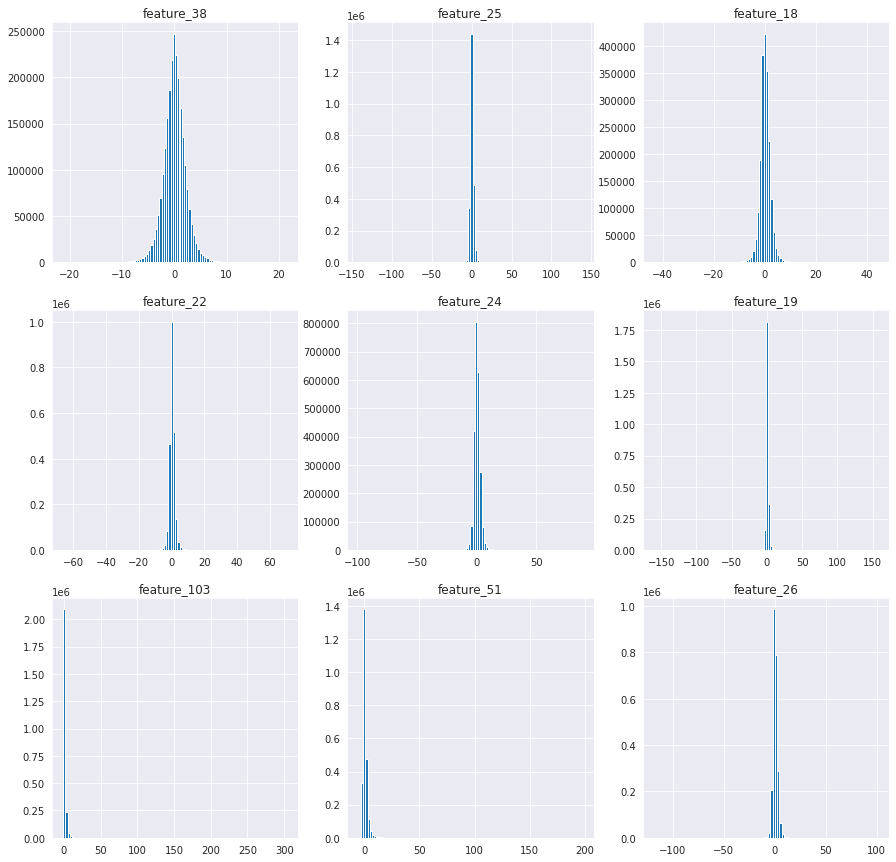

CPU times: user 7.54 s, sys: 329 ms, total: 7.87 s
Wall time: 10.7 s


<Figure size 432x288 with 0 Axes>

In [114]:
%%time
n = 3
top_corr = correlation['resp'].sort_values(ascending=True)[5:].head(n**2)
corr_features = top_corr.index.tolist()
plot_feature_histogram(train,n,corr_features)

### Find Most Skewed Features

In [ ]:
def calculate_skew(x):
    # all means and std are 0 causing pandas skew to return 0
    m3 = np.power(x.astype('float64'),3).sum()
    m2 = np.power(x.astype('float64'),2).sum()
    skew = np.divide(m3, np.power(m2,(3/2)))
    
    return skew

In [293]:
feature_skews = train[raw_feature_cols].apply(lambda x: calculate_skew(x), axis=0)

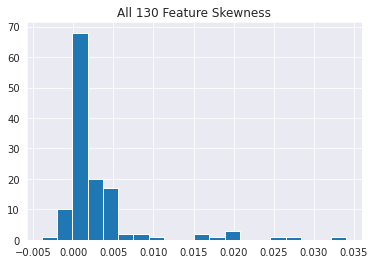

In [249]:
feature_skews.hist(bins=20)
plt.title('All 130 Feature Skewness');

In [272]:
feature_skews.sort_values(ascending=False).head()

feature_56   0.034
feature_49   0.028
feature_59   0.026
feature_50   0.019
feature_46   0.019
dtype: float64

### Plot Pos Skewed

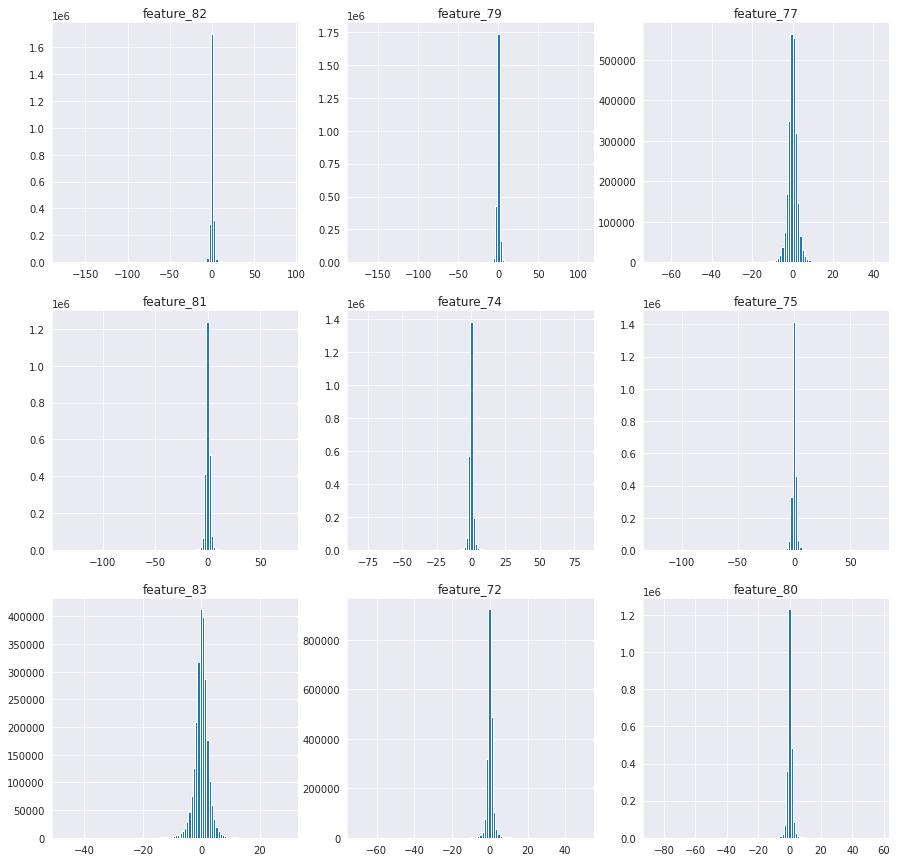

CPU times: user 7.43 s, sys: 238 ms, total: 7.66 s
Wall time: 10 s


<Figure size 432x288 with 0 Axes>

In [295]:
%%time
n = 3
top_pos_skew = feature_skews.sort_values(ascending=True).head(n**2).index.tolist()
plot_feature_histogram(train,n,top_pos_skew, apply_trans=False)

### Apply Cube Root To Normalize Data

<ipython-input-268-221a044b7c5c>:9: RuntimeWarning: invalid value encountered in power
  ax.hist(np.power(train[feat].values.astype('float64'),1/3), bins=100)


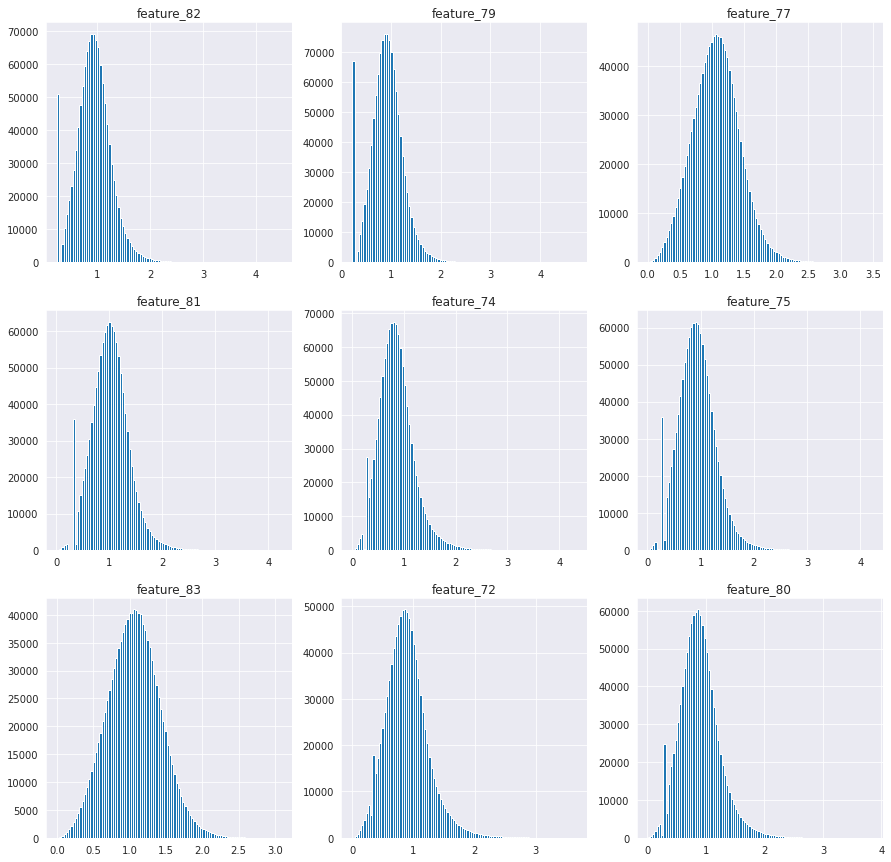

CPU times: user 5.19 s, sys: 166 ms, total: 5.36 s
Wall time: 6.42 s


<Figure size 432x288 with 0 Axes>

In [294]:
%%time
n = 3
top_pos_skew = feature_skews.sort_values(ascending=True).head(n**2).index.tolist()
plot_feature_histogram(train,n,top_pos_skew, apply_trans=True)

<AxesSubplot:>

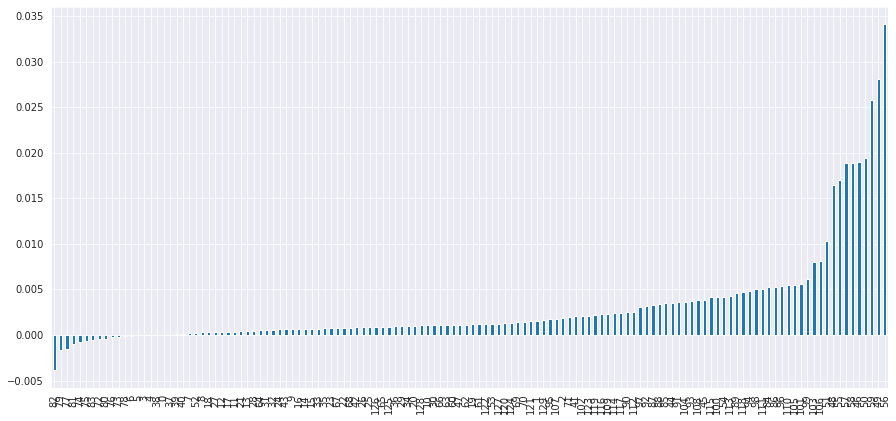

In [277]:
feature_skews.index = [col.split('_')[1] for col in feature_skews.index]
feature_skews.sort_values().plot(kind='bar',figsize=(15,7))

In [290]:
skew_trans_threshold = feature_skews['126']
skew_trans_threshold

0.0009069727516750975

### Feature Correlation

<AxesSubplot:>

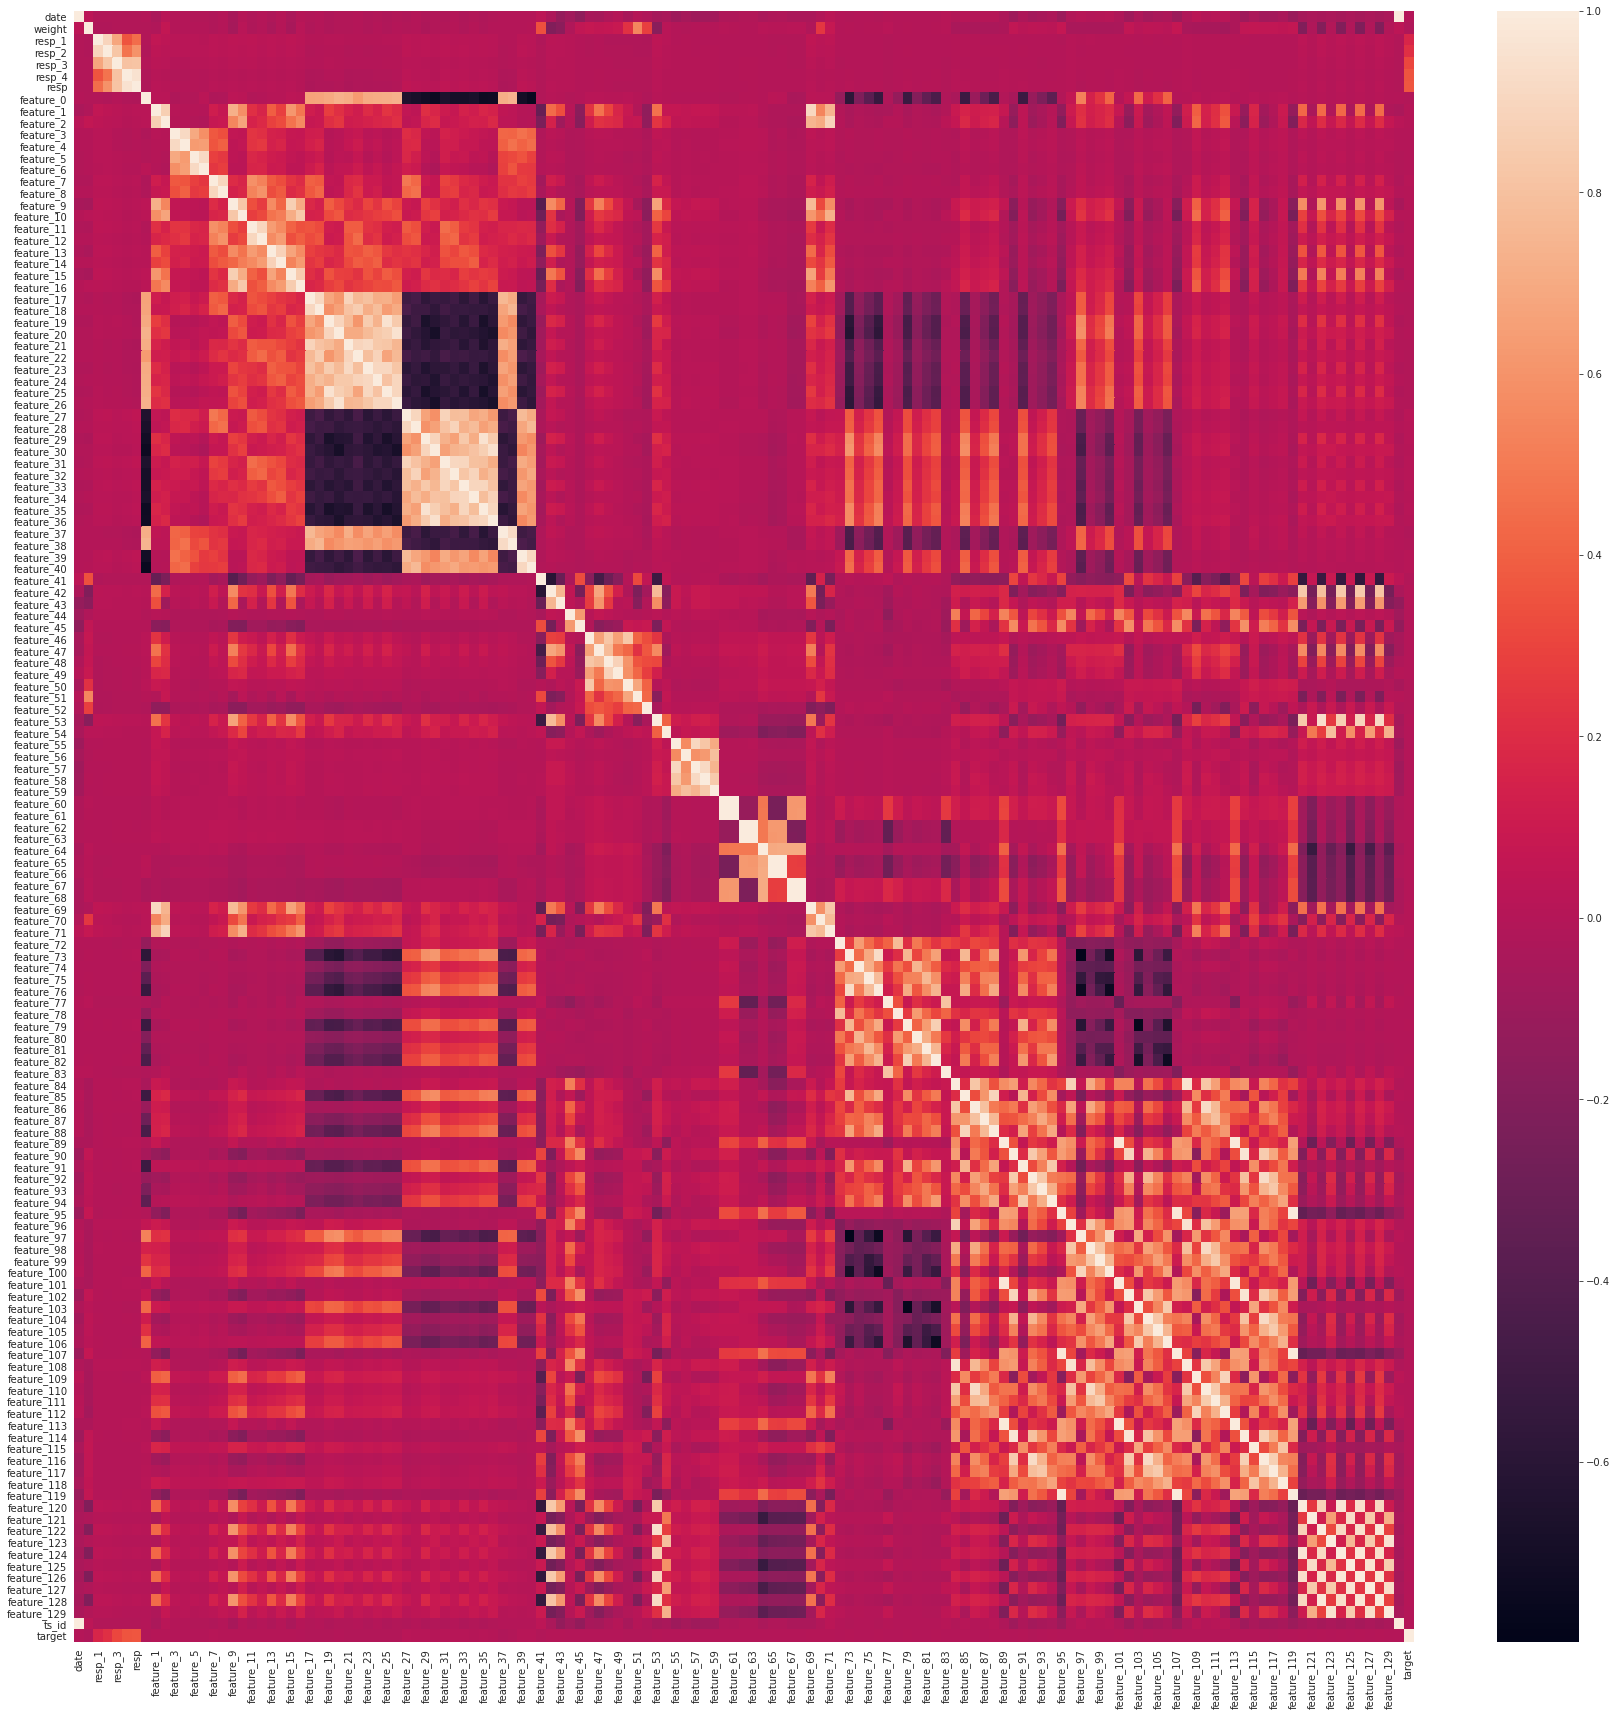

In [11]:
%%time
plt.figure(figsize=(30,30))
sns.heatmap(correlation);

- 17-26 negatively correlated with 27-36, 39, 40 at -0.6
- 27-36 hard negatvie with feature_0 (binary feature)
- 55-59 positively correlated
- 120-128 correlatted
- 84-119 corr slightly

## Feature Summary 

- Features appear to be scaled standardly
- many features are right skewed...could benefits from log transformation
    - can't be done as all features smallest value is negative ,cube root seems to work well here, still some outliers to remove
- feature 60-68 potential bimodal dist, strange disconnection...potential binning? 43 similarish...not as pronounced 
    - 60-68 seems to be of tag 22
- feature 0 is binary, balanced (-1,1)
- 52 might benefit from binning
- some features correlated...potential selection or combination 

### Feature Meta Data

In [80]:
tag_0_cols = feature_meta.columns[1:]
feature_meta_list = feature_meta.groupby('feature').apply(lambda x: list(tag_0_cols[np.argwhere(x.values.ravel() == True).flatten()-1]))

In [87]:
feature_meta_list[['feature_59','feature_60','feature_61','feature_62','feature_63','feature_64']]

feature
feature_59     [tag_1, tag_21]
feature_60    [tag_12, tag_22]
feature_61    [tag_12, tag_22]
feature_62    [tag_13, tag_22]
feature_63    [tag_13, tag_22]
feature_64            [tag_22]
dtype: object

In [190]:
feature_meta_list['feature_51']

['tag_19']

In [192]:
feature_meta.set_index('feature')[feature_meta.set_index('feature')['tag_19']==True]['tag_19']

feature
feature_46    True
feature_47    True
feature_48    True
feature_49    True
feature_50    True
feature_51    True
feature_52    True
Name: tag_19, dtype: bool

In [191]:
feature_meta_list['feature_41']

['tag_14']

In [193]:
feature_meta.set_index('feature')[feature_meta.set_index('feature')['tag_14']==True]['tag_14']

feature
feature_41    True
feature_42    True
feature_43    True
Name: tag_14, dtype: bool

In [194]:
feature_meta_list['feature_70']

['tag_16', 'tag_20']

In [195]:
feature_meta.set_index('feature')[feature_meta.set_index('feature')['tag_16']==True]['tag_16']

feature
feature_54     True
feature_70     True
feature_121    True
feature_123    True
feature_125    True
feature_127    True
feature_129    True
Name: tag_16, dtype: bool

In [196]:
feature_meta.set_index('feature')[feature_meta.set_index('feature')['tag_20']==True]['tag_20']

feature
feature_53    True
feature_54    True
feature_69    True
feature_70    True
feature_71    True
Name: tag_20, dtype: bool

### Lag Features

In [211]:
train.head()

,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,...,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id
0,0,0.000,0.010,0.014,0.009,0.001,0.006,1.000,-1.873,-2.191,...,nan,1.168,8.312,1.782,14.016,2.652,12.602,2.301,11.445,0
1,0,16.674,-0.003,-0.003,-0.007,-0.011,-0.010,-1.000,-1.350,-1.705,...,nan,-1.179,1.777,-0.916,2.832,-1.417,2.297,-1.305,1.898,1
2,0,0.000,0.025,0.028,0.033,0.034,0.024,-1.000,0.813,-0.256,...,nan,6.117,9.664,5.543,11.672,7.281,10.062,6.637,9.430,2
3,0,0.000,-0.005,-0.003,-0.000,-0.000,-0.003,-1.000,1.175,0.345,...,nan,2.838,0.499,3.033,1.514,4.398,1.266,3.855,1.014,3
4,0,0.139,0.001,0.002,-0.001,-0.006,-0.003,1.000,-3.172,-3.094,...,nan,0.345,4.102,0.614,6.625,0.800,5.234,0.363,3.926,4


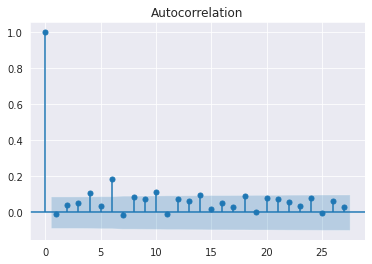

In [261]:
plot_acf(train_tar_grouped[('resp'),('std')].values);

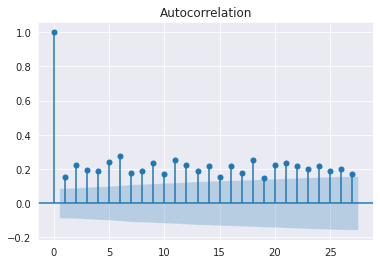

In [260]:
plot_acf(train_tar_grouped[('weight'),('mean')].values);

In [46]:
n_lags = 25
target_cols = ['resp','weight']
target_lag_cols = []
for col in target_cols:
    lag_cols = []
    print(f"Creating {col} lags...")
    for lag in tqdm(range(1, n_lags)):
        lag_col = '_'.join(['previous_trade_lag', col, str(lag)])
        lag_cols.append(lag_col)
        train_tar[lag_col] = train_tar.groupby(['date'])[col].shift(lag)
    target_lag_cols.append(lag_cols)

Creating resp lags...


<ipython-input-46-2b9a7833e78d>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for lag in tqdm(range(1, n_lags)):



Creating weight lags...


resp


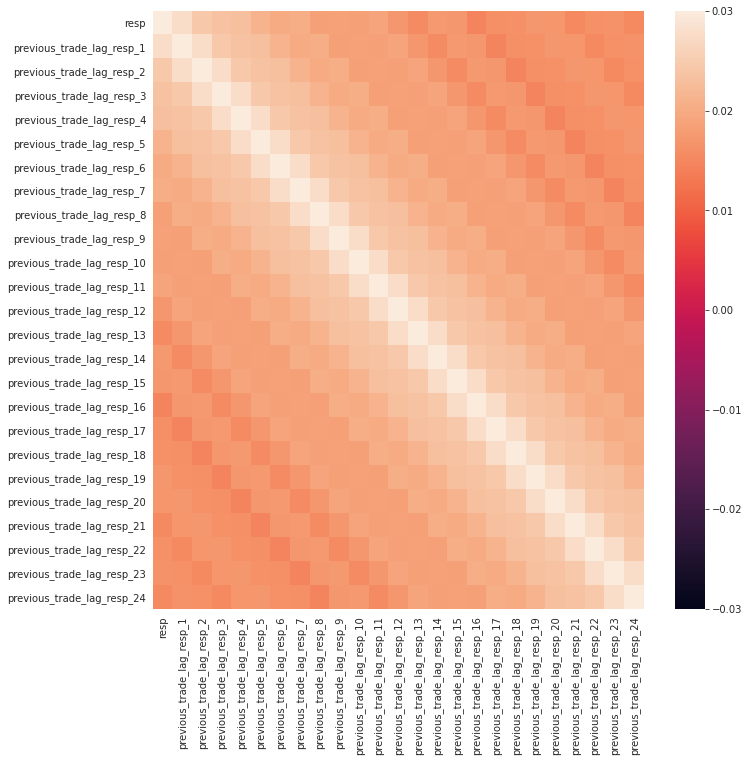

weight


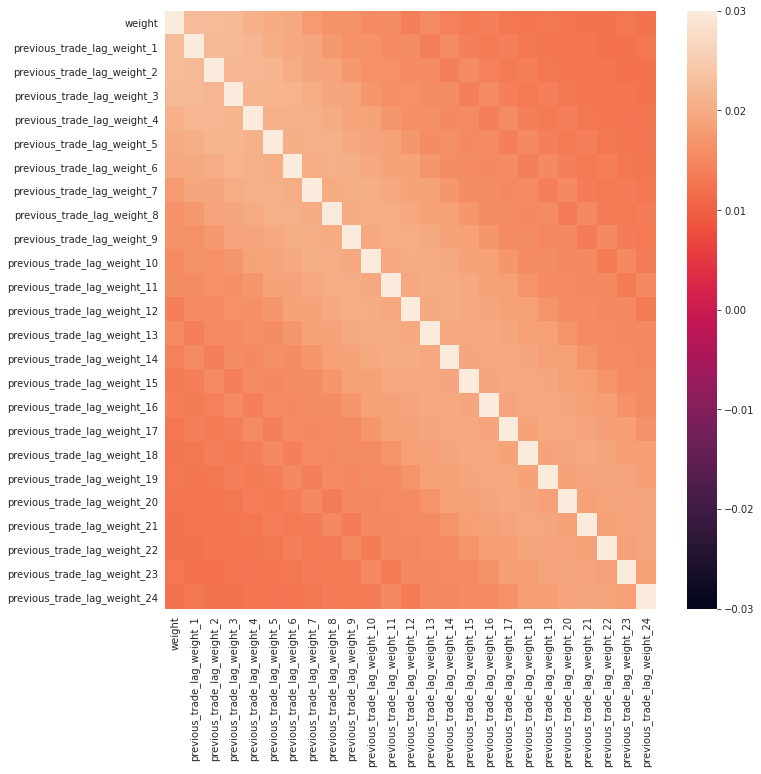

In [48]:
for i, col in enumerate(target_cols):
    print(col)
    lag_corr = train_tar[[col]+target_lag_cols[i]].corr()
    plt.figure(figsize=(11,11))
    sns.heatmap(lag_corr,vmin=-0.03,vmax=0.03)
    plt.show()

### Missing Values % of Train

In [12]:
train_na_perc = train.isna().sum()/train.shape[0]

<AxesSubplot:>

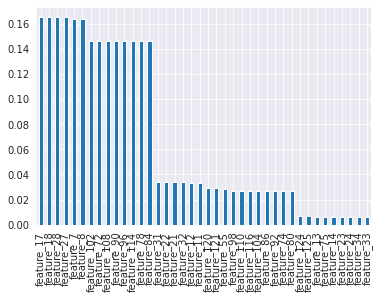

In [13]:
(train_na_perc).sort_values(ascending=False)[0:40].plot(kind='bar')

In [14]:
non_null_feats = train_na_perc[train_na_perc==0].index.tolist()
perc_thres = 0.01
non_null_feats_thres = train_na_perc[train_na_perc<perc_thres].index.tolist()
null_feats = train_na_perc[train_na_perc>0.].index.tolist()

In [16]:
print("Features with no missing values: ",len(non_null_feats))
print("Features with missing values: ",len(null_feats))
print(f"Features missing values < {perc_thres}: ",len(non_null_feats_thres))

Features with no missing values:  51
Features with missing values:  88
Features missing values < 0.01:  108


In [30]:
train_null_dummy = train[['resp']].copy()
na_dummy_cols = []
for col in tqdm(null_feats):
    col_name = '_'.join([col,'na_dummy'])
    train_null_dummy[col_name] = train[col].apply(lambda x: 1 if np.isnan(x) else 0)
    na_dummy_cols.append(col_name)

<ipython-input-30-6547ccd82537>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for col in tqdm(null_feats):


In [32]:
na_dummy_corr = train_null_dummy.corr()['resp'].sort_values(ascending=False)

In [35]:
na_dummy_corr

resp                    1.000
feature_103_na_dummy    0.000
feature_97_na_dummy     0.000
feature_91_na_dummy     0.000
feature_85_na_dummy     0.000
                        ...  
feature_22_na_dummy    -0.002
feature_44_na_dummy    -0.005
feature_4_na_dummy     -0.005
feature_3_na_dummy     -0.005
feature_45_na_dummy    -0.005
Name: resp, Length: 89, dtype: float64

### Possible Features

- yesterdays average return

In [44]:
# del correlation
# del train
# del na_dummy_col